In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
print("Import Successfull")

Import Successfull


In [20]:
# from google.colab import drive
drive.mount('/content/drive')

# DIR = '/content/drive/My Drive/Colab Notebooks/Dataset'

# # import os
# # files = os.listdir(DIR)
# # print(files)

# train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
# test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from google.colab import drive
# drive.mount('/content/drive')

import tensorflow as tf

DIR = '/content/drive/My Drive/Colab Notebooks/Dataset'

# Create the training and validation datasets without 'smart_resize'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    validation_split=0.1,
    subset="training",
    seed=42,
    batch_size=128,
    image_size=(256, 256)  # Resize images to 256x256
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    validation_split=0.1,
    subset="validation",
    seed=42,
    batch_size=128,
    image_size=(256, 256)  # Resize images to 256x256
)

# Store the class names before mapping
class_names = train_dataset.class_names
num_classes = len(class_names)
print(class_names)

# Define a resizing and rescaling layer
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(256, 256),
  tf.keras.layers.Rescaling(1./255)
])

# Apply the resizing and rescaling to the datasets
train_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y))
test_dataset = test_dataset.map(lambda x, y: (resize_and_rescale(x), y))

# Prefetch to improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Check the first batch of the training dataset
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)

# Check the first batch of the validation dataset
for images, labels in test_dataset.take(1):
    print(images.shape, labels.shape)


Found 2537 files belonging to 6 classes.
Using 2284 files for training.
Found 2537 files belonging to 6 classes.
Using 253 files for validation.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
(128, 256, 256, 3) (128,)
(128, 256, 256, 3) (128,)


In [17]:
# Define the model
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False
)

for layer in base_model.layers[:-6]:
    layer.trainable = False

last_output = base_model.layers[-1].output
x = tf.keras.layers.Dropout(0.45)(last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(
    256,
    activation=tf.keras.activations.elu,
    kernel_regularizer=tf.keras.regularizers.l1(0.045),
    activity_regularizer=tf.keras.regularizers.l1(0.045),
    kernel_initializer='he_normal'
)(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 128, 128, 16)   │            432 │ rescaling_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 128, 128, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 16)   │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 128, 128, 16)   │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 128, 128, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 128, 128, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, 129, 129, 64)   │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)      

 Total params: 3,247,750 (12.39 MB)

 Trainable params: 558,918 (2.13 MB)

 Non-trainable params: 2,688,832 (10.26 MB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 ━━━━━━━━━━━━━━━━━━━━ 284s 15s/step - accuracy: 0.1704 - loss: 1203.2019 - val_accuracy: 0.1897 - val_loss: 940.8696
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 220s 9s/step - accuracy: 0.1795 - loss: 660.5151 - val_accuracy: 0.2767 - val_loss: 730.6542
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 157s 9s/step - accuracy: 0.1598 - loss: 449.5845 - val_accuracy: 0.2806 - val_loss: 595.2501
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 156s 8s/step - accuracy: 0.2132 - loss: 371.6256 - val_accuracy: 0.2846 - val_loss: 534.7405
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 217s 9s/step - accuracy: 0.1998 - loss: 311.8976 - val_accuracy: 0.2846 - val_loss: 493.5653
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 156s 9s/step - accuracy: 0.2116 - loss: 270.5695 - val_accuracy: 0.2846 - val_loss: 452.4044
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 163s 9s/step - accuracy: 0.2257 - loss: 250.8327 - val_accuracy: 0.2885 - val_loss: 421.4255
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.2108 - loss: 218.1985 - val

In [22]:

model.save("/content/drive/My Drive/Colab Notebooks/modelMobileV3.h5")
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 128, 128, 16)   │            432 │ rescaling_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 128, 128, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 16)   │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 128, 128, 16)   │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 128, 128, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 128, 128, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, 129, 129, 64)   │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)      

 Total params: 4,365,588 (16.65 MB)

 Trainable params: 558,918 (2.13 MB)

 Non-trainable params: 2,688,832 (10.26 MB)

 Optimizer params: 1,117,838 (4.26 MB)

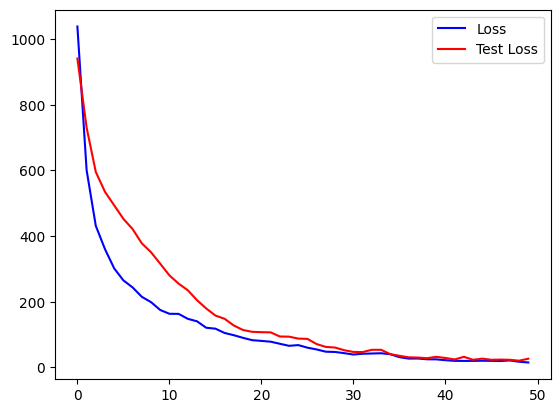

In [23]:

plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

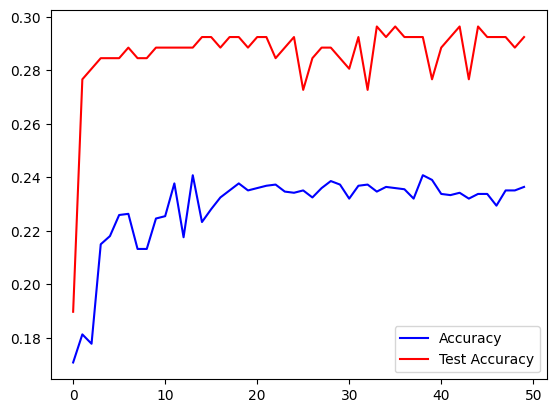

In [24]:

plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()


Text(0, 0.5, 'Loss')

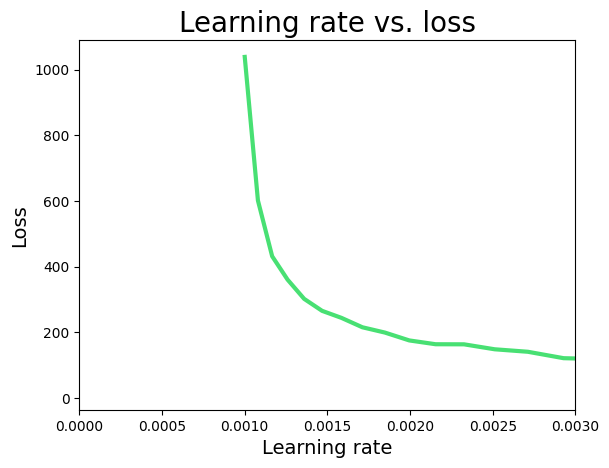

In [25]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[10.02779   24.345549  29.183748  22.031475   9.563726   4.8477106] 
 ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Prediction:  metal 29.183748364448547%


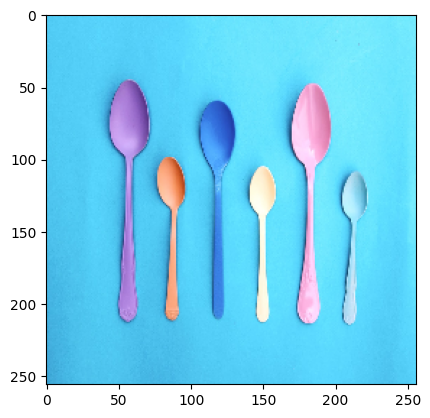

In [28]:
import requests

img_data = requests.get("https://images.unsplash.com/photo-1591872203534-278fc084969e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1064&q=80").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", class_names)
print("Prediction: ", class_names[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━

<Figure size 1000x1000 with 0 Axes>

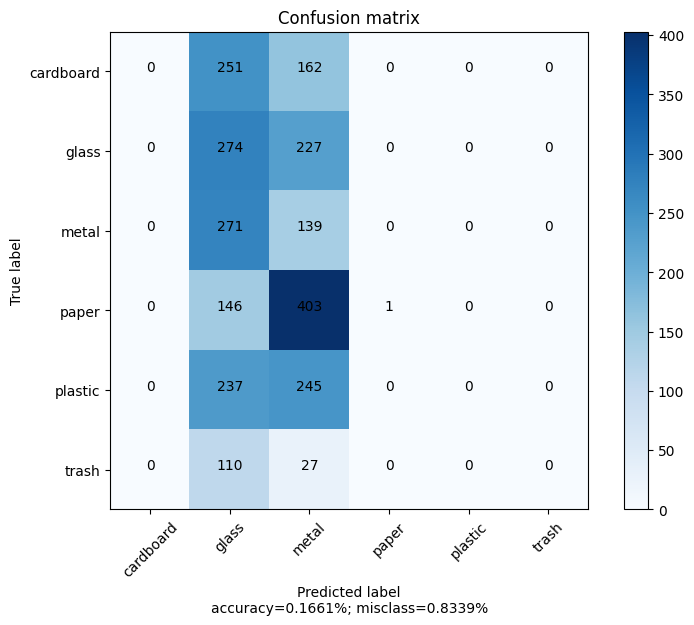

In [31]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "/content/drive/My Drive/Colab Notebooks/Dataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      preds = model.predict(img_array)
      true.append(class_names.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), class_names)


In [32]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "/content/img.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, class_names[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


ValueError: No such layer: expanded_conv_6/expand. Existing layers are: ['input_layer_4', 'rescaling_4', 'conv', 'conv_bn', 'activation', 'expanded_conv_depthwise', 'expanded_conv_depthwise_bn', 're_lu', 'expanded_conv_project', 'expanded_conv_project_bn', 'expanded_conv_add', 'expanded_conv_1_expand', 'expanded_conv_1_expand_bn', 're_lu_1', 'expanded_conv_1_depthwise_pad', 'expanded_conv_1_depthwise', 'expanded_conv_1_depthwise_bn', 're_lu_2', 'expanded_conv_1_project', 'expanded_conv_1_project_bn', 'expanded_conv_2_expand', 'expanded_conv_2_expand_bn', 're_lu_3', 'expanded_conv_2_depthwise', 'expanded_conv_2_depthwise_bn', 're_lu_4', 'expanded_conv_2_project', 'expanded_conv_2_project_bn', 'expanded_conv_2_add', 'expanded_conv_3_expand', 'expanded_conv_3_expand_bn', 're_lu_5', 'expanded_conv_3_depthwise_pad', 'expanded_conv_3_depthwise', 'expanded_conv_3_depthwise_bn', 're_lu_6', 'expanded_conv_3_squeeze_excite_avg_pool', 'expanded_conv_3_squeeze_excite_conv', 'expanded_conv_3_squeeze_excite_relu', 'expanded_conv_3_squeeze_excite_conv_1', 're_lu_7', 'expanded_conv_3_squeeze_excite_mul', 'expanded_conv_3_project', 'expanded_conv_3_project_bn', 'expanded_conv_4_expand', 'expanded_conv_4_expand_bn', 're_lu_8', 'expanded_conv_4_depthwise', 'expanded_conv_4_depthwise_bn', 're_lu_9', 'expanded_conv_4_squeeze_excite_avg_pool', 'expanded_conv_4_squeeze_excite_conv', 'expanded_conv_4_squeeze_excite_relu', 'expanded_conv_4_squeeze_excite_conv_1', 're_lu_10', 'expanded_conv_4_squeeze_excite_mul', 'expanded_conv_4_project', 'expanded_conv_4_project_bn', 'expanded_conv_4_add', 'expanded_conv_5_expand', 'expanded_conv_5_expand_bn', 're_lu_11', 'expanded_conv_5_depthwise', 'expanded_conv_5_depthwise_bn', 're_lu_12', 'expanded_conv_5_squeeze_excite_avg_pool', 'expanded_conv_5_squeeze_excite_conv', 'expanded_conv_5_squeeze_excite_relu', 'expanded_conv_5_squeeze_excite_conv_1', 're_lu_13', 'expanded_conv_5_squeeze_excite_mul', 'expanded_conv_5_project', 'expanded_conv_5_project_bn', 'expanded_conv_5_add', 'expanded_conv_6_expand', 'expanded_conv_6_expand_bn', 'activation_1', 'expanded_conv_6_depthwise_pad', 'expanded_conv_6_depthwise', 'expanded_conv_6_depthwise_bn', 'activation_2', 'expanded_conv_6_project', 'expanded_conv_6_project_bn', 'expanded_conv_7_expand', 'expanded_conv_7_expand_bn', 'activation_3', 'expanded_conv_7_depthwise', 'expanded_conv_7_depthwise_bn', 'activation_4', 'expanded_conv_7_project', 'expanded_conv_7_project_bn', 'expanded_conv_7_add', 'expanded_conv_8_expand', 'expanded_conv_8_expand_bn', 'activation_5', 'expanded_conv_8_depthwise', 'expanded_conv_8_depthwise_bn', 'activation_6', 'expanded_conv_8_project', 'expanded_conv_8_project_bn', 'expanded_conv_8_add', 'expanded_conv_9_expand', 'expanded_conv_9_expand_bn', 'activation_7', 'expanded_conv_9_depthwise', 'expanded_conv_9_depthwise_bn', 'activation_8', 'expanded_conv_9_project', 'expanded_conv_9_project_bn', 'expanded_conv_9_add', 'expanded_conv_10_expand', 'expanded_conv_10_expand_bn', 'activation_9', 'expanded_conv_10_depthwise', 'expanded_conv_10_depthwise_bn', 'activation_10', 'expanded_conv_10_squeeze_excite_avg_pool', 'expanded_conv_10_squeeze_excite_conv', 'expanded_conv_10_squeeze_excite_relu', 'expanded_conv_10_squeeze_excite_conv_1', 're_lu_14', 'expanded_conv_10_squeeze_excite_mul', 'expanded_conv_10_project', 'expanded_conv_10_project_bn', 'expanded_conv_11_expand', 'expanded_conv_11_expand_bn', 'activation_11', 'expanded_conv_11_depthwise', 'expanded_conv_11_depthwise_bn', 'activation_12', 'expanded_conv_11_squeeze_excite_avg_pool', 'expanded_conv_11_squeeze_excite_conv', 'expanded_conv_11_squeeze_excite_relu', 'expanded_conv_11_squeeze_excite_conv_1', 're_lu_15', 'expanded_conv_11_squeeze_excite_mul', 'expanded_conv_11_project', 'expanded_conv_11_project_bn', 'expanded_conv_11_add', 'expanded_conv_12_expand', 'expanded_conv_12_expand_bn', 'activation_13', 'expanded_conv_12_depthwise_pad', 'expanded_conv_12_depthwise', 'expanded_conv_12_depthwise_bn', 'activation_14', 'expanded_conv_12_squeeze_excite_avg_pool', 'expanded_conv_12_squeeze_excite_conv', 'expanded_conv_12_squeeze_excite_relu', 'expanded_conv_12_squeeze_excite_conv_1', 're_lu_16', 'expanded_conv_12_squeeze_excite_mul', 'expanded_conv_12_project', 'expanded_conv_12_project_bn', 'expanded_conv_13_expand', 'expanded_conv_13_expand_bn', 'activation_15', 'expanded_conv_13_depthwise', 'expanded_conv_13_depthwise_bn', 'activation_16', 'expanded_conv_13_squeeze_excite_avg_pool', 'expanded_conv_13_squeeze_excite_conv', 'expanded_conv_13_squeeze_excite_relu', 'expanded_conv_13_squeeze_excite_conv_1', 're_lu_17', 'expanded_conv_13_squeeze_excite_mul', 'expanded_conv_13_project', 'expanded_conv_13_project_bn', 'expanded_conv_13_add', 'expanded_conv_14_expand', 'expanded_conv_14_expand_bn', 'activation_17', 'expanded_conv_14_depthwise', 'expanded_conv_14_depthwise_bn', 'activation_18', 'expanded_conv_14_squeeze_excite_avg_pool', 'expanded_conv_14_squeeze_excite_conv', 'expanded_conv_14_squeeze_excite_relu', 'expanded_conv_14_squeeze_excite_conv_1', 're_lu_18', 'expanded_conv_14_squeeze_excite_mul', 'expanded_conv_14_project', 'expanded_conv_14_project_bn', 'expanded_conv_14_add', 'conv_1', 'conv_1_bn', 'activation_19', 'dropout', 'global_average_pooling2d', 'batch_normalization', 'dense', 'dropout_1', 'dense_1'].